In [8]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split


'''
Step 1: Split the dataset into training and testing sets
'''

# Creating Yes Sarcasm DataFrame
sarcasm_audio_files = glob.glob("audio_extracted_yes/*.mp3", recursive=True)
sarcasm_audio_df = pd.DataFrame(columns=["audio", "sarcasm"])
sarcasm_audio_df["audio"] = sarcasm_audio_files 
sarcasm_audio_df["sarcasm"] = True


# Creating Not Sarcasm DataFrame
not_sarcasm_audio_files = glob.glob("audio_extracted_no/*.mp3", recursive=True)
not_sarcasm_audio_df = pd.DataFrame(columns=["audio", "sarcasm"])
not_sarcasm_audio_df["audio"] = not_sarcasm_audio_files 
not_sarcasm_audio_df["sarcasm"] = False

#Splitting Dataset 70% training 30% testing
x_sarcasm_train, x_sarcasm_test, y_sarcasm_train, y_sarcasm_test = train_test_split(sarcasm_audio_df["audio"], sarcasm_audio_df["sarcasm"], test_size = 0.3)
x_not_sarcasm_train, x_not_sarcasm_test, y_not_sarcasm_train, y_not_sarcasm_test = train_test_split(not_sarcasm_audio_df["audio"], not_sarcasm_audio_df["sarcasm"], test_size = 0.3)

#Concat Sarcasm and Not Sarcasm Dataframe
x_train = pd.concat([x_sarcasm_train, x_not_sarcasm_train])
x_test = pd.concat([x_sarcasm_test, x_not_sarcasm_test])
y_train = pd.concat([y_sarcasm_train, y_not_sarcasm_train])
y_test = pd.concat([y_sarcasm_test, y_not_sarcasm_test])

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


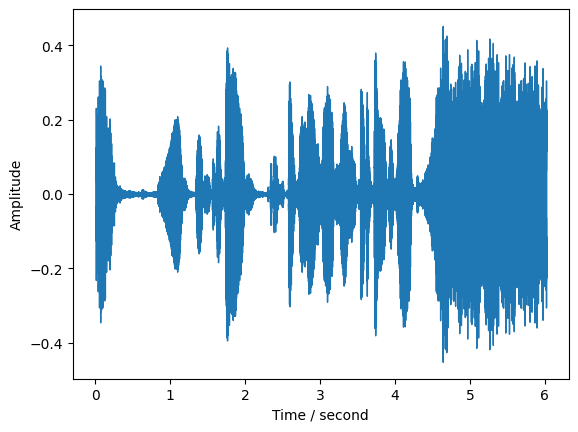

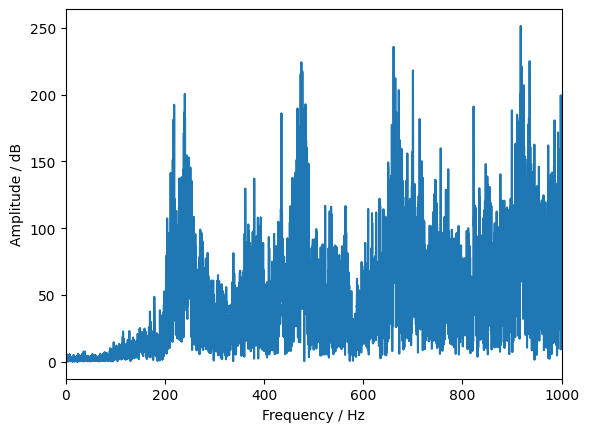

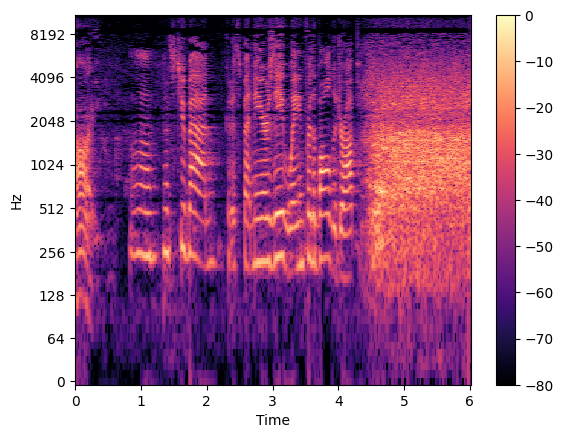

In [9]:
'''
Step 2: Exploratory Data Analysis
'''

from IPython.display import Audio

# plot audio files in time domain
signal, sample_rate = librosa.load(x_train.iloc[0])
plt.figure(1)
librosa.display.waveshow(y=signal, sr=sample_rate)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

# plot audio files in frequency domain
k = np.arange(len(signal))
T = len(signal)/sample_rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()


# plot the time-frequency variation of the audio
D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

Audio(data=signal ,rate=sample_rate)

In [10]:
'''
Step 3: Acoustic Feature Extraction 
&
Step 4: Feature Post-processing
'''

from sklearn.preprocessing import MinMaxScaler
numWindow = 17
scale = MinMaxScaler(feature_range=(-1,1))
def feature_extractor(audio_file):
    signal, sample_rate = librosa.load(audio_file)
    
    # audio feature extraction: loudness
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    df_loudness['Loudness'] = scale.fit_transform(pd.DataFrame(df_loudness['Loudness']))

    # audio feature extraction: mel-frequency cepstral coefficients
    df_mfccs = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc= numWindow)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = scale.fit_transform(pd.DataFrame(df_mfccs['MFCC_%d'%(n_mfcc+1)]))

    # audio feature extraction: zero crossing rate
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    df_zero_crossing_rate['ZCR'] = scale.fit_transform(pd.DataFrame(df_zero_crossing_rate['ZCR']))

    # audio feature extraction: chroma
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate, n_chroma=numWindow)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
        df_chroma['Chroma_%d'%(n_chroma+1)] = scale.fit_transform(pd.DataFrame(df_chroma['Chroma_%d'%(n_chroma+1)]))

    # audio feature extraction: mel spectrogram
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=numWindow)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
        df_chroma['Chroma_%d'%(n_chroma+1)] = scale.fit_transform(pd.DataFrame(df_chroma['Chroma_%d'%(n_chroma+1)]))

    # combine all features
    feature_matrix = pd.concat([df_loudness.head(numWindow), df_mfccs, df_zero_crossing_rate.head(numWindow), df_chroma, df_mel_spectrogram], axis=1)
    feature_matrix['mean'] = feature_matrix.mean(axis=1)

    return feature_matrix['mean']


x_train_df = pd.DataFrame()
for row in x_train:
    x_train_df = x_train_df.append(feature_extractor(row), ignore_index=True)
x_train = x_train_df

x_test_df = pd.DataFrame()
for row in x_test:
    x_test_df = x_test_df.append(feature_extractor(row), ignore_index=True)
x_test = x_test_df

print(x_train)
print(x_test)


C:\Users\chris\AppData\Local\Temp\ipykernel_14100\911143611.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_df = x_train_df.append(feature_extractor(row), ignore_index=True)
C:\Users\chris\AppData\Local\Temp\ipykernel_14100\911143611.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_df = x_train_df.append(feature_extractor(row), ignore_index=True)
C:\Users\chris\AppData\Local\Temp\ipykernel_14100\911143611.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_df = x_train_df.append(feature_extractor(row), ignore_index=True)
C:\Users\chris\AppData\Local\Temp\ipykernel_14100\911143611.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version.

           0         1         2         3         4         5          6   \
0   -0.394547  0.358423  0.103193  0.553491  1.475782  0.931259   0.567261   
1   -0.419752  0.605037  0.109177  0.057168 -0.029501  0.137376   0.023640   
2    0.881704  2.833222  0.484086  0.175794 -0.020115 -0.043469  -0.027162   
3   -0.586886  0.093701  0.151281  0.279508  0.181786  0.190962   0.183040   
4   -0.044645  0.697363  2.185655  6.787647  9.330298  8.798437  10.016332   
..        ...       ...       ...       ...       ...       ...        ...   
477 -0.524787  0.238165  0.335025  0.068864 -0.068253  0.014236   0.059131   
478 -0.526656  0.120753 -0.001492  0.091985  0.175060  0.253612   0.202669   
479 -0.454240  0.202098  0.163906  0.178773  0.181893  0.228991   0.196116   
480 -0.453946  0.266474 -0.081487  0.013624 -0.120406 -0.090197  -0.112185   
481 -0.502594  0.192748 -0.034949  0.361137  0.198351  0.125819   0.026181   

           7         8         9         10        11        12

C:\Users\chris\AppData\Local\Temp\ipykernel_14100\911143611.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_test_df = x_test_df.append(feature_extractor(row), ignore_index=True)


In [11]:
'''
Step 5: Build your audio emotion recognition model
'''

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

svc.fit(x_train, y_train)
nbc.fit(x_train, y_train)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [12]:
y_svc_predicted = svc.predict(x_test)
print(classification_report(y_test, y_svc_predicted))

y_nbc_predicted = nbc.predict(x_test)
print(classification_report(y_test, y_nbc_predicted))

y_rfc_predicted = rfc.predict(x_test)
print(classification_report(y_test, y_rfc_predicted))

              precision    recall  f1-score   support

       False       0.55      0.89      0.68       104
        True       0.71      0.26      0.38       104

    accuracy                           0.58       208
   macro avg       0.63      0.58      0.53       208
weighted avg       0.63      0.58      0.53       208

              precision    recall  f1-score   support

       False       0.52      0.93      0.67       104
        True       0.70      0.15      0.25       104

    accuracy                           0.54       208
   macro avg       0.61      0.54      0.46       208
weighted avg       0.61      0.54      0.46       208

              precision    recall  f1-score   support

       False       0.56      0.72      0.63       104
        True       0.61      0.43      0.51       104

    accuracy                           0.58       208
   macro avg       0.58      0.58      0.57       208
weighted avg       0.58      0.58      0.57       208

